# Data Smart Sans Excel

[Table of Contents](Data%20Smart%20Sans%20Excel.ipynb)

If you have not downloaded the Data Smart files then run the first code block of the main notebook and it will download the files from the web. 

## Chapter 4 - Optimization Modeling

In [1]:
import os
import pandas as pd
import numpy as np
excel_file = os.path.join(os.getcwd(), "data_smart_files", "ch04", "OrangeJuiceBlending.xlsx")
specs_df = pd.read_excel(excel_file, 'Specs', parse_cols = "A:I", index_col=0)

### Orange Juice Blending Problem

* Background: Planning procurement for Orange Juice production in Jan, Feb, Mar
* Objective: Minimize procurement costs
* Decisions: Amount of each juice to buy each month
* Constraints:
    * Demand: 600k in Jan/Feb, 700k in Mar
    * Supply: provided data 
    * Florida Valencia requirement: Buy 40% of juice from FL.
    * Flavor: 
        * 11.5 <= BAR <= 12.5
        * 0.0075 <= Acid <= .01
        * Astringency <= 4
    * Color: 4.5 < Color < 5.5

Said another way:

* Let:
    * $\hat{q_1} \text{ be the quantity vector for January } (\hat{q_1} \in \mathbb{R}^{9x1})$
    * $\hat{q_2} \text{ be the quantity vector for February } (\hat{q_2} \in \mathbb{R}^{9x1})$
    * $\hat{q_3} \text{ be the quantity vector for March } (\hat{q_3} \in \mathbb{R}^{9x1})$
    * $\hat{q_{1v}} \text{ be the quantity of Valencia for January } (\hat{q_{1v}} \in \hat{q_1})$ 
    * $\hat{q_{2v}} \text{ be the quantity of Valencia for February } (\hat{q_{2v}} \in \hat{q_2})$ 
    * $\hat{q_{3v}} \text{ be the quantity of Valencia for March } (\hat{q_{3v}} \in \hat{q_3})$ 
    * $\hat{p} \text{ be the price vector } (\hat{p} \in \mathbb{R}^{9x1})$
    * $\hat{t} \text{ be the shipping price vector } (\hat{t} \in \mathbb{R}^{9x1})$
    * $\hat{s} \text{ be the (available) supply vector } (\hat{s} \in \mathbb{R}^{9x1})$
    * $\hat{c_1} \text{ be the brix/acid ratio vector } (\hat{c_1} \in \mathbb{R}^{9x1})$
    * $\hat{c_2} \text{ be the acid vector } (\hat{c_2} \in \mathbb{R}^{9x1})$
    * $\hat{c_3} \text{ be the astrigency vector } (\hat{c_3} \in \mathbb{R}^{9x1})$
    * $\hat{c_4} \text{ be the color vector } (\hat{c_4} \in \mathbb{R}^{9x1})$
* $\text{minimize } f(x) = \sum{[\hat{q_1} \cdot (\hat{p} + \hat{s}) + \hat{q_2} \cdot (\hat{p} + \hat{s}) + \hat{q_3} \cdot (\hat{p} + \hat{s})]}$
    * $$
\begin{array}{c | c | c}
\sum{\hat{q_1}} = 600 & \hat{q_1} * \hat{c_1} \leq 12.5 & \hat{q_1} * \hat{c_3} \leq 4\\
\sum{\hat{q_2}} = 600 & \hat{q_1} * \hat{c_1} \geq 11.5 & \hat{q_1} * \hat{c_3} \geq 0\\
\sum{\hat{q_3}} = 700 & \hat{q_2} * \hat{c_1} \leq 12.5 & \hat{q_2} * \hat{c_3} \leq 4\\
\hat{q_1} + \hat{q_2} + \hat{q_3} \leq \hat{s} & \hat{q_2} * \hat{c_1} \geq 11.5 & \hat{q_2} * \hat{c_3} \geq 0\\
\hat{q_{1v}} \geq 600 \cdot 0.4 & \hat{q_3} * \hat{c_1} \leq 12.5 & \hat{q_3} * \hat{c_3} \leq 4\\
\hat{q_{2v}} \geq 600 \cdot 0.4 & \hat{q_3} * \hat{c_1} \geq 11.5 & \hat{q_3} * \hat{c_3} \geq 0\\
\hat{q_{3v}} \geq 600 \cdot 0.4 & \hat{q_1} * \hat{c_2} \leq 0.01 & \hat{q_1} * \hat{c_4} \leq 5.5\\
& \hat{q_1} * \hat{c_2} \geq 0.0075 & \hat{q_1} * \hat{c_4} \geq 4.5\\
& \hat{q_2} * \hat{c_2} \leq 0.01 & \hat{q_2} * \hat{c_4} \leq 5.5\\
& \hat{q_2} * \hat{c_2} \geq 0.0075 & \hat{q_2} * \hat{c_4} \geq 4.5\\
& \hat{q_3} * \hat{c_2} \leq 0.01 & \hat{q_3} * \hat{c_4} \leq 5.5\\
& \hat{q_3} * \hat{c_2} \geq 0.0075 & \hat{q_3} * \hat{c_4} \geq 4.5\\ 
\end{array}
$$

In [2]:
specs_df

,Region,"Qty Available (1,000 Gallons)",Brix / Acid Ratio,Acid (%),Astringency (1-10 Scale),Color (1-10 Scale),Price (per 1K Gallons),Shipping
Varietal,,,,,,,,
Hamlin,Brazil,672,10.5,0.0060,3,3,500,100
Mosambi,India,400,6.5,0.0140,7,1,310,150
Valencia,Florida,1200,12.0,0.0095,3,3,750,0
Hamlin,California,168,11.0,0.0100,3,5,600,60
Gardner,Arizona,84,12.0,0.0070,1,5,600,75
Sunstar,Texas,210,10.0,0.0070,1,5,625,50
Jincheng,China,588,9.0,0.0135,7,3,440,120
Berna,Spain,168,15.0,0.0110,4,8,600,110
Verna,Mexico,300,8.0,0.0130,8,3,300,90


In [3]:
from scipy.optimize import linprog
num_months = 3
suppliers = 11

bar = specs_df['Brix / Acid Ratio']
acid = specs_df['Acid (%)']
ast = specs_df['Astringency (1-10 Scale)']
color = specs_df['Color (1-10 Scale)']
stacked_bar = np.hstack((bar,bar,bar))
stacked_acid = np.hstack((acid,acid,acid))
stacked_ast = np.hstack((ast,ast,ast))
stacked_color = np.hstack((color,color,color))

target_total_qty = [600,600,700]

jan_identity = np.hstack((np.ones(suppliers), np.zeros(suppliers), np.zeros(suppliers)))
feb_identity = np.hstack((np.zeros(suppliers), np.ones(suppliers), np.zeros(suppliers)))
mar_identity = np.hstack((np.zeros(suppliers), np.zeros(suppliers), np.ones(suppliers)))

qty_avail = np.array(specs_df['Qty Available (1,000 Gallons)'])
supply_checker_base = np.hstack((1,np.zeros(10),1,np.zeros(10),1,np.zeros(10)))
supply_checker = np.zeros((suppliers,suppliers*num_months))
for i in range(suppliers):
    supply_checker[i,:] = np.roll(supply_checker_base,i)

jan_avger = jan_identity / target_total_qty[0]
feb_avger = feb_identity / target_total_qty[1]
mar_avger = mar_identity / target_total_qty[2]

valencia_req = np.array([x*0.4 for x in target_total_qty])
valencia_checker1 = np.zeros(suppliers * num_months)
valencia_checker2 = np.zeros(suppliers * num_months)
valencia_checker3 = np.zeros(suppliers * num_months)
v_ = (valencia_checker1,valencia_checker2,valencia_checker3)
valencia_loc = [2 + x for x in np.multiply(range(num_months),suppliers)]
for i, v in enumerate(valencia_loc):
    v_[i][v] = 1

In [4]:
# A_eq is a 3 x 33 matrix. 3 is the number of months (giving us 3 equations to set equal to the 3 months' 
# production constraints. 33 is the number of X variables (number of suppliers x number of months).
A_eq = np.vstack((jan_identity,feb_identity,mar_identity))
# b_eq is a 3 element array consisting of the 3 monthly production constraints. 
b_eq = np.array(target_total_qty)

A_eq_orig = A_eq.copy()
b_eq_orig = b_eq.copy()

In [5]:
# A_ub is a 38 x 33 matrix. 38 is the number of constraint equations. 
# 33 is the number of X variables (number of suppliers x number of months).
A_ub = np.vstack((supply_checker,
                  -valencia_checker1,
                  -valencia_checker2,
                  -valencia_checker3,
                  jan_avger * stacked_bar,
                  -jan_avger * stacked_bar,
                  feb_avger * stacked_bar,
                  -feb_avger * stacked_bar,
                  mar_avger * stacked_bar,
                  -mar_avger * stacked_bar,
                  jan_avger * stacked_acid,
                  -jan_avger * stacked_acid,
                  feb_avger * stacked_acid,
                  -feb_avger * stacked_acid,
                  mar_avger * stacked_acid,
                  -mar_avger * stacked_acid,
                  jan_avger * stacked_ast,
                  -jan_avger * stacked_ast,
                  feb_avger * stacked_ast,
                  -feb_avger * stacked_ast,
                  mar_avger * stacked_ast,
                  -mar_avger * stacked_ast,
                  jan_avger * stacked_color,
                  -jan_avger * stacked_color,
                  feb_avger * stacked_color,
                  -feb_avger * stacked_color,
                  mar_avger * stacked_color,
                  -mar_avger * stacked_color))
# b_ub is a 38 element array where each element is the upper bound of one of the constraint equations. 
b_ub = np.hstack((qty_avail,
                  -valencia_req,
                  np.tile([12.5,-11.5],3),
                  np.tile([0.01,-0.0075],3),
                  np.tile([4,0],3),
                  np.tile([5.5,-4.5],3)))

A_ub_orig = A_ub.copy()
b_ub_orig = b_ub.copy()

In [6]:
# c is a 33 element array and is being multiplied by X and being minimized by the algorithm 
c_ = np.array(specs_df['Price (per 1K Gallons)'] + specs_df['Shipping'])
c = np.array([c_,c_,c_]).reshape(num_months * suppliers)

c_orig = c.copy()

In [7]:
res = linprog(c, A_eq=A_eq, b_eq=b_eq,
              A_ub=A_ub, b_ub=b_ub,bounds=(0, None),options={"disp": True})
print('Optimal value:', '${0:,.2f}'.format(res.fun))

Optimization terminated successfully.
         Current function value: 1227560.000000
         Iterations: 57
Optimal value: $1,227,560.00


Data Smart calculated $1,227,560, so we are right on.

In [8]:
buy = res.x.reshape(3,11).T
print ('Buys by month:',buy.sum(axis=0))
print ('Buys by month and varietal:')
buy_df = pd.DataFrame(buy,columns=['Jan','Feb','Mar'])
buy_df.index = specs_df.index
buy_df = buy_df.applymap(lambda x: np.round(x,1))
buy_df

Buys by month: [ 600.  600.  700.]
Buys by month and varietal:


,Jan,Feb,Mar
Varietal,,,
Hamlin,0.0,0.0,0.0
Mosambi,0.0,13.5,0.0
Valencia,240.0,240.0,280.0
Hamlin,0.0,0.0,111.2
Gardner,52.2,0.0,31.8
Sunstar,64.3,9.0,0.0
Jincheng,0.0,0.0,0.0
Berna,77.4,0.0,90.6
Verna,52.6,112.8,134.6


In [9]:
combined_df = pd.concat((buy_df,specs_df),axis=1)
combined_df['Total Buy'] = combined_df['Jan'] + combined_df['Feb'] + combined_df['Mar']
combined_df['Jan Price'] = combined_df['Jan'] * combined_df['Price (per 1K Gallons)']
combined_df['Feb Price'] = combined_df['Feb'] * combined_df['Price (per 1K Gallons)']
combined_df['Mar Price'] = combined_df['Mar'] * combined_df['Price (per 1K Gallons)']
combined_df['Jan Shipping'] = combined_df['Jan'] * combined_df['Shipping']
combined_df['Feb Shipping'] = combined_df['Feb'] * combined_df['Shipping']
combined_df['Mar Shipping'] = combined_df['Mar'] * combined_df['Shipping']
combined_df[['Jan','Feb','Mar','Total Buy','Jan Price','Feb Price','Mar Price','Jan Shipping','Feb Shipping','Mar Shipping']]

,Jan,Feb,Mar,Total Buy,Jan Price,Feb Price,Mar Price,Jan Shipping,Feb Shipping,Mar Shipping
Varietal,,,,,,,,,,
Hamlin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mosambi,0.0,13.5,0.0,13.5,0.0,4185.0,0.0,0.0,2025.0,0.0
Valencia,240.0,240.0,280.0,760.0,180000.0,180000.0,210000.0,0.0,0.0,0.0
Hamlin,0.0,0.0,111.2,111.2,0.0,0.0,66720.0,0.0,0.0,6672.0
Gardner,52.2,0.0,31.8,84.0,31320.0,0.0,19080.0,3915.0,0.0,2385.0
Sunstar,64.3,9.0,0.0,73.3,40187.5,5625.0,0.0,3215.0,450.0,0.0
Jincheng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Berna,77.4,0.0,90.6,168.0,46440.0,0.0,54360.0,8514.0,0.0,9966.0
Verna,52.6,112.8,134.6,300.0,15780.0,33840.0,40380.0,4734.0,10152.0,12114.0


In [10]:
for m in ('Jan','Feb','Mar'):
    print(m,'Total:','${0:,.2f}'.format((combined_df[m+' Price'] + combined_df[m+' Shipping']).sum(axis=0)))
print('Total:','${0:,.2f}'.format((combined_df['Jan Price'] + combined_df['Jan Shipping']).sum(axis=0)+
                                  (combined_df['Feb Price'] + combined_df['Feb Shipping']).sum(axis=0)+
                                  (combined_df['Mar Price'] + combined_df['Mar Shipping']).sum(axis=0)))

Jan Total: $401,528.50
Feb Total: $372,238.00
Mar Total: $453,793.00
Total: $1,227,559.50


This does not exactly match the purchase plan computed in the book, but it gets the job done. See the book's result below.

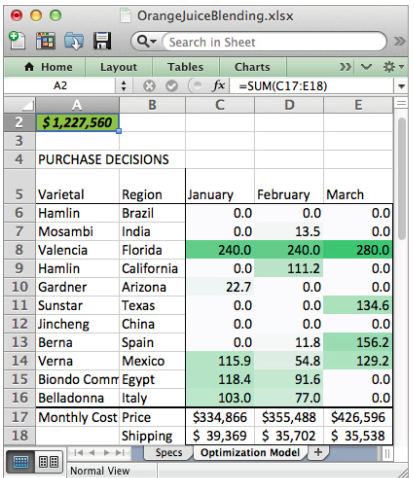

In [11]:
from IPython.display import Image
Image(filename='images/oj_blend_solution.png') 

### Orange Juice Blending Problem (Relaxed)

* Background: The boss wants to reduce the cost by 5% (new cost of \$1,170,000)
* Objective: Minimize average quality reduction to meet new cost
* Decisions: Amount of each juice to buy each month
* Constraints:
    * Price: Price <= $1,170,000
    * Demand: 600k in Jan/Feb, 700k in Mar
    * Supply: provided data 
    * Florida Valencia requirement: Buy 40% of juice from FL.
    * Flavor: 
        * 11.5 - Redux <= BAR <= 12.5 + Redux
        * 0.0075 - Redux \* 0.0025 <= Acid <= .01 + Redux \* 0.0025
        * Astringency <= 4 + Redux \* 4
    * Color: 4.5 - Redux <= Color <= 5.5 + Redux

In [12]:
# Note: the below code assumes the above code has been executed. 

# 5 new columns are being added for the 4 qual factors and the average.
# the 4 qual factor columns are set based on need to set:
#          Min - Relax * (Max - Min)
#          Max + Relax * (Max - Min)
# Per the last run things are set to:
#      For the max we want Average QF for all orders <= Max QF
#      For the min we want -Average QF for all orders <= -Min QF
# This means that for max we now want Average - Relax * (Max-Min) <= Max
# and for min we want -(Average + Relax * (Max-Min)) <= -Min 
# since "Relax" is our variable we just want our multiplier to be max-min
# the 5th column is set to zero
# _neg and _pos versions are created because in all cases the negative
# is needed, but below the array is negated in some places.
stacked_bar_neg = np.hstack((stacked_bar,[-1,0,0,0,0]))
stacked_acid_neg = np.hstack((stacked_acid,[0,-0.0025,0,0,0]))
stacked_ast_neg = np.hstack((stacked_ast,[0,0,-4,0,0]))
stacked_color_neg = np.hstack((stacked_color,[0,0,0,-1,0]))
stacked_bar_pos = np.hstack((stacked_bar,[1,0,0,0,0]))
stacked_acid_pos = np.hstack((stacked_acid,[0,0.0025,0,0,0]))
stacked_ast_pos = np.hstack((stacked_ast,[0,0,4,0,0]))
stacked_color_pos = np.hstack((stacked_color,[0,0,0,1,0]))

target_total_qty = [600,600,700]

if len(jan_identity) == suppliers * num_months:
    jan_identity = np.append(jan_identity,np.zeros(5))
if len(feb_identity) == suppliers * num_months:
    feb_identity = np.append(feb_identity,np.zeros(5))
if len(mar_identity) == suppliers * num_months:
    mar_identity = np.append(mar_identity,np.zeros(5))

if supply_checker.shape[1] == suppliers * num_months:
    supply_checker = np.hstack((supply_checker,np.zeros((suppliers,5))))

if len(jan_avger) == suppliers * num_months:
    jan_avger = np.append(jan_avger,np.ones(5))
if len(feb_avger) == suppliers * num_months:
    feb_avger = np.append(feb_avger,np.ones(5))
if len(mar_avger) == suppliers * num_months:
    mar_avger = np.append(mar_avger,np.ones(5))

if len(valencia_checker1) == suppliers * num_months:
    valencia_checker1 = np.append(valencia_checker1,np.zeros(5))
if len(valencia_checker2) == suppliers * num_months:
    valencia_checker2 = np.append(valencia_checker2,np.zeros(5))
if len(valencia_checker3) == suppliers * num_months:
    valencia_checker3 = np.append(valencia_checker3,np.zeros(5))

price_checker_ = np.array(specs_df['Price (per 1K Gallons)'] + specs_df['Shipping'])
price_checker = np.array([price_checker_,price_checker_,price_checker_]).reshape(num_months * suppliers)
price_checker = np.hstack((price_checker,np.zeros(5)))

In [13]:
# A_eq is a 4 x 38 matrix. The first 3 rows matches the number of months (and their provided 
# production constraints. The last row is used to set column 38 to the average of columns 34-37)
# The first 33 columns are number of suppliers x number of months. The last 5 columns are the 4
# relaxation factors (BAR, asid, astrigency, color) and the average value (the one being minimized)
A_eq = np.vstack((jan_identity,feb_identity,mar_identity,
                  np.hstack((np.zeros(suppliers*num_months),[1,1,1,1,-4]))))
# b_eq is a 4 element array consisting of the 3 monthly production constraints and a 0 which is used to
# define the relaxation average as the average of the 4 relaxation factors (f1+f2+f3-4*avg=0)
b_eq = np.hstack((target_total_qty,0))

In [14]:
# A_ub is a 39 x 38 matrix. 39 is the number of constraint equations. 
# The first 33 columns are number of suppliers x number of months. The last 5 columns are the 4
# relaxation factors (BAR, asid, astrigency, color) and the average value (the one being minimized).
A_ub = np.vstack((supply_checker,
                  -valencia_checker1,
                  -valencia_checker2,
                  -valencia_checker3,
                  jan_avger * stacked_bar_neg,
                  -jan_avger * stacked_bar_pos,
                  feb_avger * stacked_bar_neg,
                  -feb_avger * stacked_bar_pos,
                  mar_avger * stacked_bar_neg,
                  -mar_avger * stacked_bar_pos,
                  jan_avger * stacked_acid_neg,
                  -jan_avger * stacked_acid_pos,
                  feb_avger * stacked_acid_neg,
                  -feb_avger * stacked_acid_pos,
                  mar_avger * stacked_acid_neg,
                  -mar_avger * stacked_acid_pos,
                  jan_avger * stacked_ast_neg,
                  -jan_avger * stacked_ast_pos,
                  feb_avger * stacked_ast_neg,
                  -feb_avger * stacked_ast_pos,
                  mar_avger * stacked_ast_neg,
                  -mar_avger * stacked_ast_pos,
                  jan_avger * stacked_color_neg,
                  -jan_avger * stacked_color_pos,
                  feb_avger * stacked_color_neg,
                  -feb_avger * stacked_color_pos,
                  mar_avger * stacked_color_neg,
                  -mar_avger * stacked_color_pos,
                  price_checker))
# b_ub is a 39 element array where each element is the upper bound of one of the constraint equations. 
b_ub = np.hstack((qty_avail,
                  -valencia_req,
                  np.tile([12.5,-11.5],3),
                  np.tile([0.01,-0.0075],3),
                  np.tile([4,0],3),
                  np.tile([5.5,-4.5],3),
                  1170000))

In [15]:
# c is a 38 element array starting with suppliers x number of months, followed by the
# 4 relaxation factors, and finally the average relaxation factor. All elements are set 
# to zero except for the average relaxation factor (as it is the one being minimized)
c = np.hstack((np.zeros(suppliers*num_months),0,0,0,0,1))

In [16]:
res = linprog(c, A_eq=A_eq, b_eq=b_eq,
              A_ub=A_ub, b_ub=b_ub,bounds=(0, None),options={"disp": True})
print('Optimal value:', '{0:,.2f}%'.format(res.fun*100))
print('Price:', '${0:,.2f}'.format((res.x * price_checker).sum()))

Optimization terminated successfully.
         Current function value: 0.347656    
         Iterations: 75
Optimal value: 34.77%
Price: $1,170,000.00


In [17]:
buy = res.x[:suppliers*num_months].reshape(3,11).T
print ('Buys by month:',buy.sum(axis=0))
print ('Buys by month and varietal:')
buy_df = pd.DataFrame(buy,columns=['Jan','Feb','Mar'])
buy_df.index = specs_df.index
buy_df = buy_df.applymap(lambda x: np.round(x,1))
buy_df

Buys by month: [ 600.  600.  700.]
Buys by month and varietal:


,Jan,Feb,Mar
Varietal,,,
Hamlin,77.6,77.6,92.2
Mosambi,48.8,48.8,81.6
Valencia,240.0,240.0,280.0
Hamlin,0.0,0.0,0.0
Gardner,0.0,0.0,0.0
Sunstar,0.0,0.0,0.0
Jincheng,0.0,0.0,0.0
Berna,0.0,0.0,23.4
Verna,102.5,102.5,95.1


In [18]:
relax_factors = res.x[-5:] * 100
print ('Relax Factor for BAR:\t\t{0:.1f}%'.format(relax_factors[0]))
print ('Relax Factor for Acid:\t\t{0:.1f}%'.format(relax_factors[1]))
print ('Relax Factor for Astringency:\t{0:.1f}%'.format(relax_factors[2]))
print ('Relax Factor for Color:\t\t{0:.1f}%'.format(relax_factors[3]))
print ('Average Relax Factor:\t\t{0:.1f}%'.format(relax_factors[4]))

Relax Factor for BAR:		50.8%
Relax Factor for Acid:		0.0%
Relax Factor for Astringency:	4.5%
Relax Factor for Color:		83.7%
Average Relax Factor:		34.8%


Data Smart calculated these relaxation factors:
* BAR - 50.8%
* Acid - 0%
* Astringency - 4.7%
* Color - 83.7%
* Average - 34.8%

These are quite close to the values calculated here. 

Rerun for various prices to determine the relationship between price and the reduction in quality. 

In [19]:
%matplotlib notebook
price_vs_relaxed_qual = pd.DataFrame(columns=('Price','BAR Redux','Acid Redux',
                                               'Astr Redux','Color Redux','Avg Redux'))
b_ub_vary = b_ub.copy()
for i, price in enumerate(range(1250000,1110000,-10000)):
    b_ub_vary[-1] = price
    res = linprog(c, A_eq=A_eq, b_eq=b_eq,
                  A_ub=A_ub, b_ub=b_ub_vary,bounds=(0, None),options={"disp": False})
    price_vs_relaxed_qual.loc[i] = np.hstack((price,res.x[-5:]))

In [20]:
price_vs_relaxed_qual

,Price,BAR Redux,Acid Redux,Astr Redux,Color Redux,Avg Redux
0,1250000.0,0.000000,0.000000,0.000000,0.000000,8.018759e-16
1,1240000.0,0.000000,0.000000,0.000000,0.000000,1.665335e-16
2,1230000.0,0.000000,0.000000,0.000000,0.000000,9.053088e-17
3,1220000.0,0.000000,0.000000,0.000000,0.088421,2.210526e-02
4,1210000.0,0.000000,0.000000,0.000000,0.215320,5.383001e-02
5,1200000.0,0.000000,0.000000,0.011046,0.343343,8.859708e-02
6,1190000.0,0.135376,0.000000,0.024734,0.504330,1.661101e-01
7,1180000.0,0.321919,0.000000,0.034727,0.670886,2.568829e-01
8,1170000.0,0.508461,0.000000,0.044720,0.837442,3.476557e-01
9,1160000.0,0.675564,0.064662,0.069549,0.954887,4.411654e-01


In [21]:
price_vs_relaxed_qual = price_vs_relaxed_qual.set_index('Price',drop=True)
price_vs_relaxed_qual.sort_index(ascending=True,inplace=True)

<IPython.core.display.Javascript object>


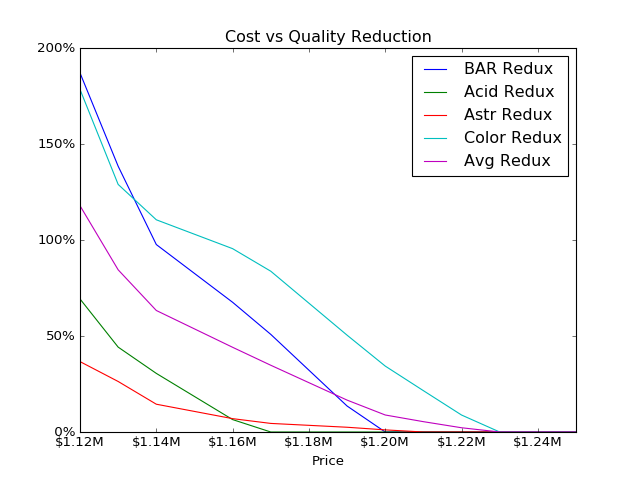

In [22]:
ax = price_vs_relaxed_qual.plot(title='Cost vs Quality Reduction')
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['${:.2f}M'.format(x/1000000) for x in vals])

### Orange Juice Blending Problem (Minimax Relaxed)

* Background: The boss wants to reduce the cost by 5% (new cost of \$1,170,000)
* Objective: Minimize **maximum** quality reduction to meet new cost
* Decisions: Amount of each juice to buy each month
* Constraints:
    * Price: Price <= $1,170,000
    * Demand: 600k in Jan/Feb, 700k in Mar
    * Supply: provided data 
    * Florida Valencia requirement: Buy 40% of juice from FL.
    * Flavor: 
        * 11.5 - Redux <= BAR <= 12.5 + Redux
        * 0.0075 - Redux \* 0.0025 <= Acid <= .01 + Redux \* 0.0025
        * Astringency <= 4 + Redux \* 4
    * Color: 4.5 - Redux <= Color <= 5.5 + Redux

In [23]:
# Note: the below code assumes the above code has been executed. 

# Modify A_eq
# remove the 4th equality constraint (4th row). This is the one used to set the 
# 38th element as the average of elements 34-37.
if A_eq.shape == (4, 38):
    A_eq = np.delete(A_eq,3,0)
    
# Modify b_eq
# remove 4th element as 4th equation was removed
if b_eq.shape == (4,):
    b_eq = np.delete(b_eq,3,0)

# Modify A_ub
# append 4 new equations to ensure that each of the 4 relaxation factors are less than the max
# factor (which we will minimize)
if A_ub.shape == (39, 38):
    A_ub = np.vstack((A_ub,
                   np.hstack((np.zeros(33),[1,0,0,0,-1])),
                   np.hstack((np.zeros(33),[0,1,0,0,-1])),
                   np.hstack((np.zeros(33),[0,0,1,0,-1])),
                   np.hstack((np.zeros(33),[0,0,0,1,-1]))))

# Modify b_ub
# add 4 zeros as part of the 4 new equations
if b_ub.shape == (39,):
    b_ub = np.hstack((b_ub,np.zeros(4)))

# No need to modify c as it is the same as the previous relaxation case (minimize final element)

A_eq_minimax, b_eq_minimax, A_ub_minimax, b_ub_minimax, c_minimax = A_eq, b_eq, A_ub, b_ub, c

In [24]:
res = linprog(c, A_eq=A_eq, b_eq=b_eq,
              A_ub=A_ub, b_ub=b_ub,bounds=(0, None),options={"disp": True})
print('Optimal value:', '{0:,.2f}%'.format(res.fun*100))
print('Price:', '${0:,.2f}'.format((res.x * price_checker).sum()))

Optimization terminated successfully.
         Current function value: 0.587368    
         Iterations: 38
Optimal value: 58.74%
Price: $1,170,000.00


In [25]:
buy = res.x[:suppliers*num_months].reshape(3,11).T
print ('Buys by month:',buy.sum(axis=0))
print ('Buys by month and varietal:')
buy_df = pd.DataFrame(buy,columns=['Jan','Feb','Mar'])
buy_df.index = specs_df.index
buy_df = buy_df.applymap(lambda x: np.round(x,1))
buy_df

Buys by month: [ 600.  600.  700.]
Buys by month and varietal:


,Jan,Feb,Mar
Varietal,,,
Hamlin,0.0,0.0,0.0
Mosambi,0.0,192.6,95.4
Valencia,240.0,240.0,280.0
Hamlin,0.0,0.0,0.0
Gardner,0.0,0.0,0.0
Sunstar,0.0,0.0,0.0
Jincheng,0.0,0.0,0.0
Berna,90.1,71.9,0.0
Verna,221.4,0.0,78.6


In [26]:
relax_factors = res.x[-5:] * 100
print ('Relax Factor for BAR:\t\t{0:.1f}%'.format(relax_factors[0]))
print ('Relax Factor for Acid:\t\t{0:.1f}%'.format(relax_factors[1]))
print ('Relax Factor for Astringency:\t{0:.1f}%'.format(relax_factors[2]))
print ('Relax Factor for Color:\t\t{0:.1f}%'.format(relax_factors[3]))
print ('Max Relax Factor:\t\t{0:.1f}%'.format(relax_factors[4]))

Relax Factor for BAR:		58.7%
Relax Factor for Acid:		52.0%
Relax Factor for Astringency:	24.9%
Relax Factor for Color:		58.7%
Max Relax Factor:		58.7%


58.7% matches Data Smart.

<IPython.core.display.Javascript object>


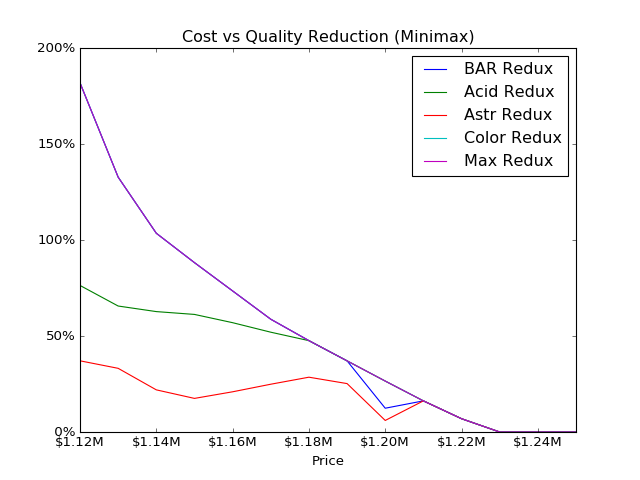

In [27]:
price_vs_relaxed_qual = pd.DataFrame(columns=('Price','BAR Redux','Acid Redux',
                                               'Astr Redux','Color Redux','Max Redux'))
b_ub_vary = b_ub.copy()
for i, price in enumerate(range(1250000,1110000,-10000)):
    b_ub_vary[-5] = price
    res = linprog(c, A_eq=A_eq, b_eq=b_eq,
                     A_ub=A_ub, b_ub=b_ub_vary,
                     bounds=(0, None),options={"disp": False})
    price_vs_relaxed_qual.loc[i] = np.hstack((price,res.x[-5:]))
price_vs_relaxed_qual = price_vs_relaxed_qual.set_index('Price',drop=True)
price_vs_relaxed_qual.sort_index(ascending=True,inplace=True)
ax = price_vs_relaxed_qual.plot(title='Cost vs Quality Reduction (Minimax)')
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = ax.get_xticks()
ax.set_xticklabels(['${:.2f}M'.format(x/1000000) for x in vals])

### Orange Juice Blending Problem (Big-M)

* Background: Purchasing refuses to procure juice in any given month from more than four suppliers
* Objective: Minimize procurement costs
* Decisions: Amount of each juice to buy each month (limited to 4 suppliers)
* Constraints:
    * Demand: 600k in Jan/Feb, 700k in Mar
    * Supply: provided data 
    * Florida Valencia requirement: Buy 40% of juice from FL.
    * Flavor: 
        * 11.5 <= BAR <= 12.5
        * 0.0075 <= Acid <= .01
        * Astringency <= 4
    * Color: 4.5 < Color < 5.5
    
**Note:** this will not work using scikit.optimize.linprog as this assume the variables are all continuous (thus does not support the binary variables). Because of this, Pulp is being used as it supports Mixed Integer Linear Programming(MILP).

In [28]:
import pulp

In [29]:
oj_model = pulp.LpProblem('OJ - Big M', pulp.LpMinimize)
sups = list(specs_df.index)
prices = list(specs_df['Price (per 1K Gallons)'] + specs_df['Shipping'])
sups_mnths = []
prices_x3 = []
for m in range(3):
    for s in sups:
        sups_mnths.append(s+'_'+str(m+1))
    prices_x3.extend(prices)
prices_dict = dict(zip(sups_mnths, prices_x3))
orders = dict(zip(sups_mnths, range(33)))

x1=pulp.LpVariableDict('Orders',orders,lowBound=0,upBound=None,cat=pulp.LpContinuous)
x2=pulp.LpVariableDict('Switches',orders,lowBound=0,upBound=1,cat=pulp.LpBinary)

oj_model += pulp.lpSum(x1[i] for i in sups_mnths), 'orders'
# oj_model += pulp.lpSum(x2[i] for i in sups_mnths), 'switcher'
oj_model += pulp.lpSum(x1[i] for i in sups_mnths[:11]) == 600, 'jan orders'
oj_model += pulp.lpSum(x1[i] for i in sups_mnths[11:22]) == 600, 'feb orders'
oj_model += pulp.lpSum(x1[i] for i in sups_mnths[22:33]) == 700, 'mar orders'
for a, b, s_m in zip(A_ub_orig , b_ub_orig, sups_mnths):
    oj_model += pulp.lpSum(a * x1[s_m]) <= b, 'upper bound for '+s_m+str(np.random.rand(1))
big_m_arr = np.hstack((qty_avail,qty_avail,qty_avail))
switcher = np.zeros((suppliers * num_months, suppliers * num_months))
orderer = np.zeros((suppliers * num_months, suppliers * num_months))
roller = np.hstack((1,np.zeros(suppliers * num_months - 1)))
for i in range(suppliers * num_months):
    switcher[i,:] = - big_m_arr * np.roll(roller,i)
    orderer[i,:] = np.roll(roller,i)
for sw, ordr, s_m in zip(switcher, orderer, sups_mnths):
    oj_model += pulp.lpSum(sw * x1[s_m] + ordr * x2[s_m]) <= 0, 'switcher'+s_m+str(np.random.rand(1))
switch_counter = np.vstack((np.hstack((np.ones(11),np.zeros(11),np.zeros(11))),
                                       np.hstack((np.zeros(11),np.ones(11),np.zeros(11))),
                                       np.hstack((np.zeros(11),np.zeros(11),np.ones(11)))))

for sw, s_m in zip(switch_counter, sups_mnths):
    oj_model += pulp.lpSum(sw * x2[s_m]) <= 4, 'sw counter' + s_m+str(np.random.rand(1))
oj_model.writeLP("oj_model.lp")
oj_model.solve()

-1

Data Smart computed an optimized cost of $1,243,658. 

**Note:** Currently the Pulp solve isn't working for me. More research is needed, but for now I am moving on. 

### Optimization Model Integer Acid

This is also a Mixed Integer Linear Programming (MILP) problem and thus cannot be used by scikit's linprog. For now, I am skipping this. 

### Modeling Risk

Given a standard deviation for each supplier's quality factors, recompute the optimized solution. The goal is to find a blending plan that is less than $1.25 million dollars and best meets the quality expectations in light of supplier variability.

In [30]:
specs_variability_df = pd.read_excel(excel_file, 'Specs Variability', parse_cols = "A:M", index_col=0, skiprows=1)
specs_variability_df

,Region,"Qty Available (1,000 Gallons)",Brix / Acid Ratio,Acid (%),Astringency (1-10 Scale),Color (1-10 Scale),Price (per 1K Gallons),Shipping,Brix / Acid Ratio.1,Acid (%).1,Astringency (1-10 Scale).1,Color (1-10 Scale).1
Varietal,,,,,,,,,,,,
Hamlin,Brazil,672,10.5,0.0060,3,3,500,100,2.0,0.0012,0.70,1.0
Mosambi,India,400,6.5,0.0140,7,1,310,150,1.1,0.0009,0.05,1.3
Valencia,Florida,1200,12.0,0.0095,3,3,750,0,0.2,0.0019,0.70,1.4
Hamlin,California,168,11.0,0.0100,3,5,600,60,1.0,0.0018,0.90,0.9
Gardner,Arizona,84,12.0,0.0070,1,5,600,75,1.3,0.0013,0.60,0.3
Sunstar,Texas,210,10.0,0.0070,1,5,625,50,1.4,0.0009,0.40,1.0
Jincheng,China,588,9.0,0.0135,7,3,440,120,0.3,0.0019,0.20,0.3
Berna,Spain,168,15.0,0.0110,4,8,600,110,0.8,0.0012,0.40,0.9
Verna,Mexico,300,8.0,0.0130,8,3,300,90,1.0,0.0017,0.50,0.2


In [31]:
# Note: the below code assumes the above code has been executed. 

# We want to optimize over 100 sets of quality factors (rahter than 1 set).
# The quality factors are in A_ub, rows 14-37 - 24 rows, 6 rows per quality factor
# cols 1-33 are the qual factors (3 months x 11 suppliers)
# cols 34-37 are the 4 relaxation parameters and 38 is the max (we will reuse these)

# The prior problem constructed 6 equations per QF which was for 1 scenario. In this
# problem there are 100 scenerios which equates to 600 equations per QF. This means we 
# replace 24 equations with 2400 equations

# Step 1: Generate the 4 x 11 x 100 (4 factors, 11 suppliers, 100 scenerios) arrays of factors
# extract standard deviations
bar_sd = specs_variability_df['Brix / Acid Ratio.1']
acid_sd = specs_variability_df['Acid (%).1']
ast_sd = specs_variability_df['Astringency (1-10 Scale).1']
color_sd = specs_variability_df['Color (1-10 Scale).1']
# generate new quality factors
mega_bar = np.random.normal(bar, bar_sd,(100,11))
mega_bar = np.hstack((mega_bar,mega_bar,mega_bar))
mega_acid = np.random.normal(acid, acid_sd,(100,11))
mega_acid = np.hstack((mega_acid,mega_acid,mega_acid))
mega_ast = np.random.normal(ast, ast_sd,(100,11))
mega_ast = np.hstack((mega_ast,mega_ast,mega_ast))
mega_color = np.random.normal(color, color_sd,(100,11))
mega_color = np.hstack((mega_color,mega_color,mega_color))

# Step 2: Augment linprog variables using Minimax run as baseline
(A_eq, b_eq, A_ub, b_ub, c) = (A_eq_minimax.copy(), b_eq_minimax.copy(), 
                               A_ub_minimax.copy(), b_ub_minimax.copy(), 
                               c_minimax.copy())

relax_params = A_ub[14:38,33:]
A_ub = np.delete(A_ub,range(14,38),axis=0)
A_ub = np.insert(A_ub,14,np.zeros((2400,38)),axis=0)
for i in range(100):
    factors = np.vstack((jan_avger[:33] * mega_bar[i,:],
                         -jan_avger[:33] * mega_bar[i,:],
                         feb_avger[:33] * mega_bar[i,:],
                         -feb_avger[:33] * mega_bar[i,:],
                         mar_avger[:33] * mega_bar[i,:],
                         -mar_avger[:33] * mega_bar[i,:],
                         jan_avger[:33] * mega_acid[i,:],
                         -jan_avger[:33] * mega_acid[i,:],
                         feb_avger[:33] * mega_acid[i,:],
                         -feb_avger[:33] * mega_acid[i,:],
                         mar_avger[:33] * mega_acid[i,:],
                         -mar_avger[:33] * mega_acid[i,:],
                         jan_avger[:33] * mega_ast[i,:],
                         -jan_avger[:33] * mega_ast[i,:],
                         feb_avger[:33] * mega_ast[i,:],
                         -feb_avger[:33] * mega_ast[i,:],
                         mar_avger[:33] * mega_ast[i,:],
                         -mar_avger[:33] * mega_ast[i,:],
                         jan_avger[:33] * mega_color[i,:],
                         -jan_avger[:33] * mega_color[i,:],
                         feb_avger[:33] * mega_color[i,:],
                         -feb_avger[:33] * mega_color[i,:],
                         mar_avger[:33] * mega_color[i,:],
                         -mar_avger[:33] * mega_color[i,:]))
    start = i*24+14
    end = start+24
    A_ub[start:end,:] = np.hstack((factors,relax_params))

b_ub[-5] = 1250000 # price
b_ub = np.delete(b_ub,range(14,38))
b_ub = np.insert(b_ub,14,np.zeros(2400))
for i in range(100):
    start = i*24+14
    end = start+24
    b_ub[start:end] = np.hstack((np.tile([12.5,-11.5],3),
                                 np.tile([0.01,-0.0075],3),
                                 np.tile([4,0],3),
                                 np.tile([5.5,-4.5],3)))

# Step 3: Rerun the optimization algo with new inputs
res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub,
              bounds=(0, None),options={"disp": True})

Optimization failed. Unable to find a feasible starting point.


The above optimization is failing. I am going to dump the data and take a look.

In [34]:
l = [[s+'_'+str(i+1) for i in range(11)] for s in ('Jan','Feb','Mar')]
columns = []
for ll in l: columns.extend(ll)
columns.extend(['relax_bar','relax_acid','relax_ast','relax_color','relax_minimax','b/lte'])
for_dmp = pd.DataFrame(np.hstack((A_ub,np.reshape(b_ub,(b_ub.size,1)))),columns=columns)
for_dmp.to_csv('monte.csv')

Data looks as expected. I will try and determine if it is specific to a set of constraints.
Below will walk through all 100 scenarios and run the optimization as if it is the only scenario. 

In [35]:
scenarios = []
for i in range(100):
    start = i*24+14
    end = start+24
    scenarios.append(A_ub[start:end])
A_ub_test = np.delete(A_ub,range(14,2414),axis=0)
b_ub_test = np.delete(b_ub,range(14+24,2414))
A_ub_test = np.insert(A_ub_test,14,np.zeros((24,38)),axis=0)
loop_thru_scn = np.zeros((100,2))
for i in range(100):
    A_ub_test[14:38,:] = scenarios[i]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub_test, b_ub=b_ub_test,
                  bounds=(0, None),options={"disp": False})
    loop_thru_scn[i,0] = res.success
    loop_thru_scn[i,1] = res.fun
successes = loop_thru_scn[:,0]
print (np.where(successes==0)[0].size,'scenarios (out of 100) failed as only scenario.')

1 scenarios (out of 100) failed as only scenario.


I do not know why these scenarios are failing.
I will try and remove these "maybe bad" scenarios and see what happens. 

In [36]:
for_removal = []
for i in range(100):
    if successes[i] == 0:
        start = i*24+14
        end = start+24
        for_removal.extend(range(start,end))
A_ub_reduced = np.delete(A_ub,for_removal,axis=0)
b_ub_reduced = np.delete(b_ub,for_removal)

print('The arrays were reduced by',len(b_ub) - len(b_ub_reduced),
      'rows ({} scenarios).'.format(np.where(successes==0)[0].size))
assert (len(b_ub) - len(b_ub_reduced))/24 == np.where(successes==0)[0].size

res = linprog(c, A_eq=A_eq, b_eq=b_eq,A_ub=A_ub_reduced, b_ub=b_ub_reduced,
              bounds=(0, None),options={"disp": True})

The arrays were reduced by 24 rows (1 scenarios).
Optimization failed. Unable to find a feasible starting point.


Removed these "maybe bad" scenarios, but this did not fix the problem. 
I am going to loop through the remaining scenarios and see if I can determine if there is a single bad actor.

In [38]:
for r in np.where(successes==0)[0]:
    scenarios.pop(r)
remaining_scn = len(scenarios)

slicer = list(range(14)) # init as the initial 14 rows to keep
loop_thru_scn2 = np.zeros((remaining_scn,7))
good_sequence = []
everything = list(range(remaining_scn))
for i in range(remaining_scn):
    if i % 10 == 0 and i > 0:
        print('{} runs - {} successes, {} failures'.format(i,len(good_sequence),
                                                           i-len(good_sequence)))
    for n,ii in enumerate(np.random.permutation(everything)):
        try_this = ii
        start = try_this*24+14
        end = start+24
        slicer_to_try = slicer.copy()
        slicer_to_try.extend(range(start,end))
        A_ub_reduced2 = A_ub_reduced[slicer_to_try,:]
        b_ub_reduced2 = b_ub_reduced[slicer_to_try]
        res = linprog(c, A_eq=A_eq, b_eq=b_eq,A_ub=A_ub_reduced2, b_ub=b_ub_reduced2,
                      bounds=(0, None),options={"disp": False})
        if res.success:
            slicer.extend(range(start,end))
            everything.remove(try_this)
            good_sequence.append(try_this)
            loop_thru_scn2[i,0] = try_this
            loop_thru_scn2[i,1] = n
            loop_thru_scn2[i,2] = len(slicer)
            loop_thru_scn2[i,3] = A_ub_reduced2.shape[0]
            loop_thru_scn2[i,4] = res.success
            loop_thru_scn2[i,5] = res.fun
            loop_thru_scn2[i,6] = res.nit
            break
print('Finished - {} runs - {} successes, {} failures'.format(i+1,len(good_sequence),
                                                              i+1-len(good_sequence)))

10 runs - 10 successes, 0 failures
20 runs - 16 successes, 4 failures
30 runs - 16 successes, 14 failures
40 runs - 16 successes, 24 failures
50 runs - 16 successes, 34 failures
60 runs - 16 successes, 44 failures
70 runs - 16 successes, 54 failures
80 runs - 16 successes, 64 failures
90 runs - 16 successes, 74 failures
Finished - 98 runs - 16 successes, 82 failures


Clearly, more than 1 "bad actor" (or, as is more likely, I am completely missing something). 
For now, I am going to let this one lie...